# Comparison of 2D segmentation techniques on upper and middle liver slices

This notebook provides a comparison of several segmentation techniques present in `skimage.segmentation` applied to MRI slices, focusing on acquiring the liver's borders.

**Authors:**
* Mateus Riva
* Larissa de O. Penteado

Please note: all MRI images in this notebook are window-leveled for ease of visualization of the liver; significant borders may exist between visually super/subsaturated regions.

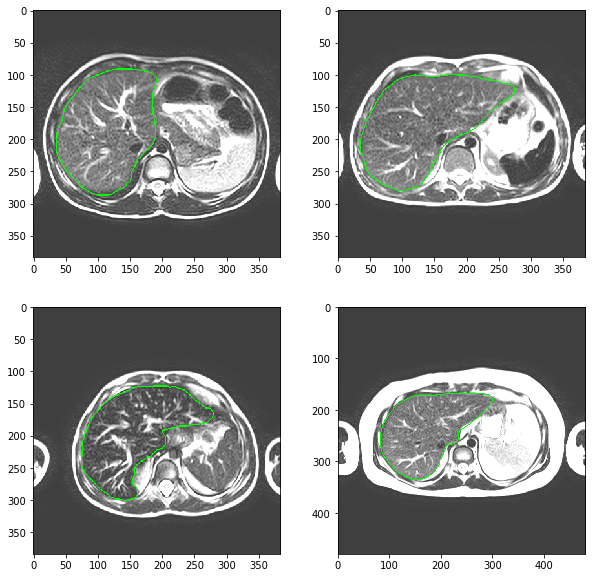

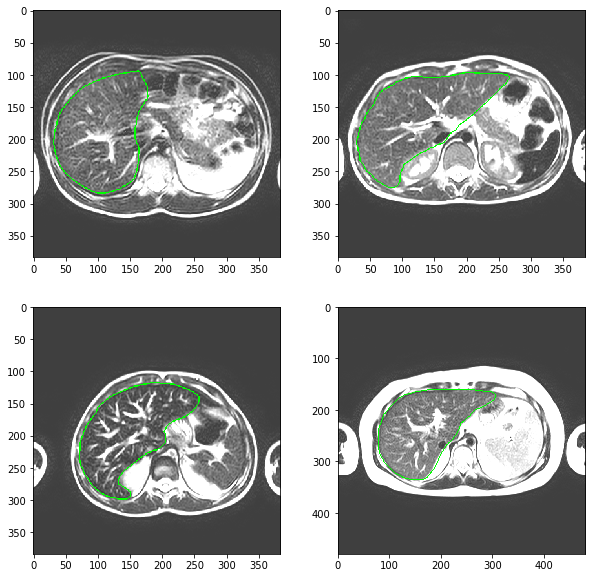

In [7]:
%matplotlib inline

"""Loading and displaying data, directly as 2D arrays"""
import numpy as np
import pydicom
import matplotlib.pyplot as plt
from time import time
import skimage, skimage.segmentation, skimage.measure, skimage.filters, skimage.morphology, skimage.future.graph

# Note: sorry for the code golfing; this is just data loading and so is unimportant.

# Loading images
# Upper slices for patients 1-4
upper_slices = [pydicom.read_file("notebooks_data/2d_liver_slices/{}_upper.dcm".format(patient)).pixel_array for patient in [1,2,3,4]]
# Portal slices for patients 1-4
portal_slices = [pydicom.read_file("notebooks_data/2d_liver_slices/{}_portal.dcm".format(patient)).pixel_array for patient in [1,2,3,4]]

def window_level(image, w=400, l=100):
    """Window-levels the image."""
    leveled = image.astype(float)
    leveled = (leveled-(l-(w/2)))/(w)
    leveled[leveled < 0.0] = 0.0
    leveled[leveled > 1.0] = 1.0
    return leveled

# Loading truth
upper_truths = [skimage.io.imread("notebooks_data/2d_liver_slices/ground_truth/{}_upper.png".format(patient)) > 0 for patient in [1,2,3,4]]
portal_truths = [skimage.io.imread("notebooks_data/2d_liver_slices/ground_truth/{}_portal.png".format(patient)) > 0 for patient in [1,2,3,4]]

# Displaying loaded data
fig, axarr = plt.subplots(2,2, figsize=(10,10))
axarr[0,0].imshow(skimage.segmentation.mark_boundaries(window_level(upper_slices[0]), upper_truths[0], mode="thick", color=(0,1,0)), cmap="gray")
axarr[0,1].imshow(skimage.segmentation.mark_boundaries(window_level(upper_slices[1]), upper_truths[1], mode="thick", color=(0,1,0)), cmap="gray")
axarr[1,0].imshow(skimage.segmentation.mark_boundaries(window_level(upper_slices[2]), upper_truths[2], mode="thick", color=(0,1,0)), cmap="gray")
axarr[1,1].imshow(skimage.segmentation.mark_boundaries(window_level(upper_slices[3]), upper_truths[3], mode="thick", color=(0,1,0)), cmap="gray")

fig, axarr = plt.subplots(2,2, figsize=(10,10))
axarr[0,0].imshow(skimage.segmentation.mark_boundaries(window_level(portal_slices[0]), portal_truths[0], mode="thick", color=(0,1,0)), cmap="gray")
axarr[0,1].imshow(skimage.segmentation.mark_boundaries(window_level(portal_slices[1]), portal_truths[1], mode="thick", color=(0,1,0)), cmap="gray")
axarr[1,0].imshow(skimage.segmentation.mark_boundaries(window_level(portal_slices[2]), portal_truths[2], mode="thick", color=(0,1,0)), cmap="gray")
axarr[1,1].imshow(skimage.segmentation.mark_boundaries(window_level(portal_slices[3]), portal_truths[3], mode="thick", color=(0,1,0)), cmap="gray")


### Distributing local minima markers

We will distribute markers along the local minima of the gradient image (computed using Sobel's filter).

We have two parameters to adjust: the $\sigma$ of the Gaussian blur and the radius $r$ of the local minima structuring element. Let's qualitatively explore the permutations of $\sigma, r \in \{3,5,7\}$.

Patient 2 Upper - Sigma=3, R=3
Liver/Total markers: 337/24948 (1.35%), 0.09261s
Patient 2 Upper - Sigma=3, R=3
Liver/Total markers: 280/69095 (0.41%), 0.11442s


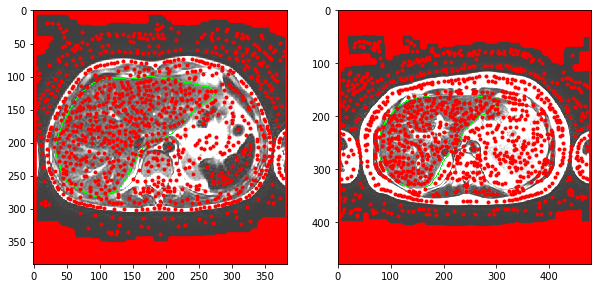

Patient 2 Upper - Sigma=3, R=5
Liver/Total markers: 234/24623 (0.95%), 0.10123s
Patient 2 Upper - Sigma=3, R=5
Liver/Total markers: 197/68708 (0.29%), 0.13590s


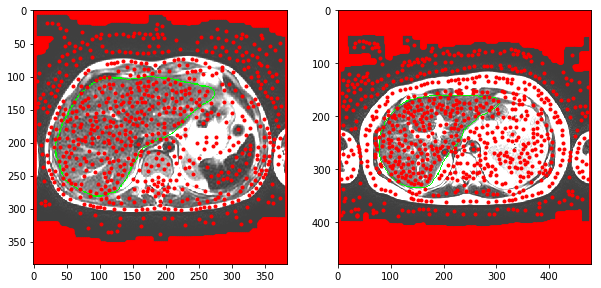

Patient 2 Upper - Sigma=3, R=7
Liver/Total markers: 152/24412 (0.62%), 0.11549s
Patient 2 Upper - Sigma=3, R=7
Liver/Total markers: 140/68472 (0.20%), 0.16327s


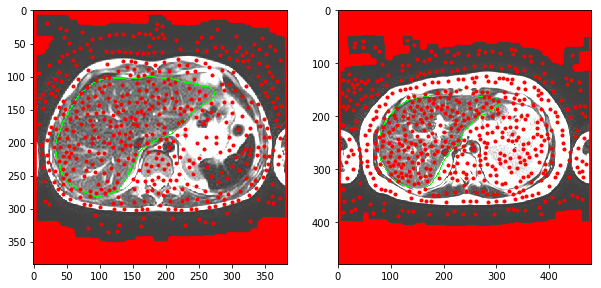

Patient 2 Upper - Sigma=5, R=3
Liver/Total markers: 149/17077 (0.87%), 0.08607s
Patient 2 Upper - Sigma=5, R=3
Liver/Total markers: 128/56536 (0.23%), 0.11651s


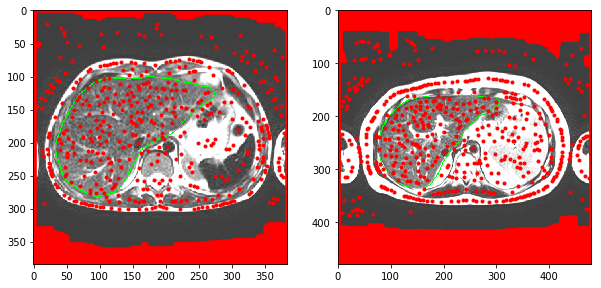

Patient 2 Upper - Sigma=5, R=5
Liver/Total markers: 131/16978 (0.77%), 0.09806s
Patient 2 Upper - Sigma=5, R=5
Liver/Total markers: 116/56399 (0.21%), 0.14211s


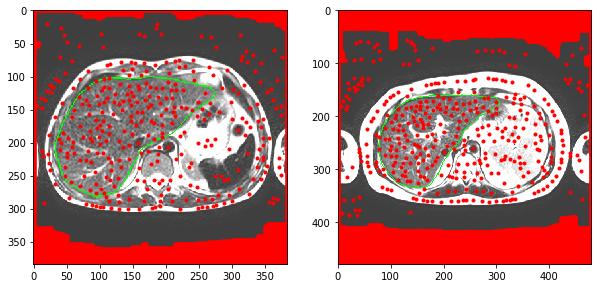

Patient 2 Upper - Sigma=5, R=7
Liver/Total markers: 113/16917 (0.67%), 0.11638s
Patient 2 Upper - Sigma=5, R=7
Liver/Total markers: 104/56338 (0.18%), 0.15938s


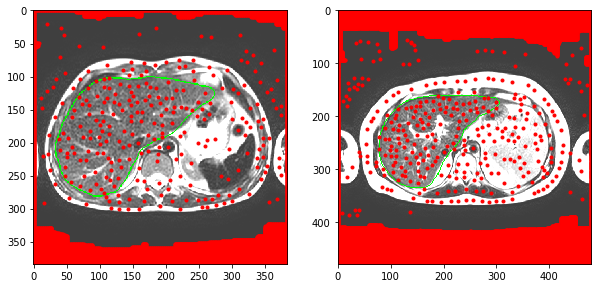

Patient 2 Upper - Sigma=7, R=3
Liver/Total markers: 83/11357 (0.73%), 0.08091s
Patient 2 Upper - Sigma=7, R=3
Liver/Total markers: 76/46522 (0.16%), 0.11725s


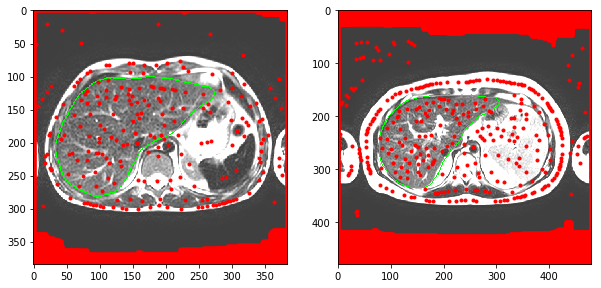

Patient 2 Upper - Sigma=7, R=5
Liver/Total markers: 73/11319 (0.64%), 0.09519s
Patient 2 Upper - Sigma=7, R=5
Liver/Total markers: 69/46432 (0.15%), 0.14446s


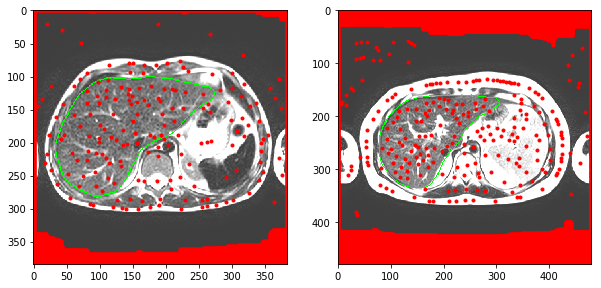

Patient 2 Upper - Sigma=7, R=7
Liver/Total markers: 65/11303 (0.58%), 0.11153s
Patient 2 Upper - Sigma=7, R=7
Liver/Total markers: 66/46402 (0.14%), 0.18939s


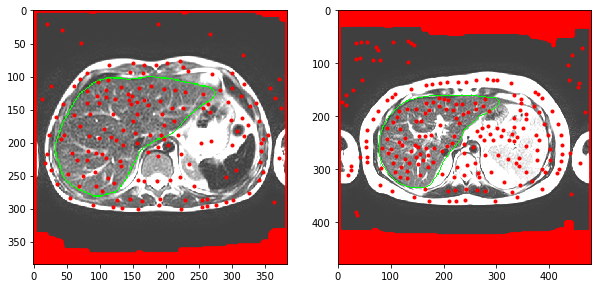

In [2]:
def local_minima_markers(image,sigma=5,r=5):
    """Returns local minima markers after gaussian smoothing with `sigma` and with selem as a ball of radius `r`"""
    smoothed = skimage.filters.gaussian(image, sigma)
    smoothed = smoothed/np.max(smoothed) # normalization for magnitude
    magnitude = skimage.filters.sobel(smoothed)
    local_minima = skimage.morphology.local_minima(magnitude, selem=skimage.morphology.disk(r))
    return skimage.measure.label(local_minima)

for sigma in [3,5,7]:
    for r in [3,5,7]:
        # Getting markers for Patient #2 upper slice
        t0 = time()
        upper_markers = local_minima_markers(upper_slices[1], sigma, r)
        t1 = time()
        # Computing total markers and inner liver markers
        total_markers, inner_liver_markers = np.count_nonzero(upper_markers), np.count_nonzero(np.logical_and(upper_markers > 0, upper_truths[1]))
        print("Patient 2 Upper - Sigma={}, R={}\nLiver/Total markers: {}/{} ({:.2f}%), {:.5f}s".format(sigma, r, inner_liver_markers, total_markers, inner_liver_markers*100/total_markers, t1-t0))
        plt.figure(figsize=(10,10))
        plt.subplot(121)
        plt.imshow(skimage.segmentation.mark_boundaries(window_level(upper_slices[1]), upper_truths[1], mode="thick", color=(0,1,0)), cmap="gray")
        y, x = np.where(upper_markers > 0)
        plt.plot(x, y, "r.")

        # Getting markers for Patient #4 portal slice
        t0 = time()
        portal_markers = local_minima_markers(portal_slices[3], sigma, r)
        t1 = time()
        # Computing total markers and inner liver markers
        total_markers, inner_liver_markers = np.count_nonzero(portal_markers), np.count_nonzero(np.logical_and(portal_markers > 0, portal_truths[3]))
        print("Patient 2 Upper - Sigma={}, R={}\nLiver/Total markers: {}/{} ({:.2f}%), {:.5f}s".format(sigma, r, inner_liver_markers, total_markers, inner_liver_markers*100/total_markers, t1-t0))
        plt.subplot(122)
        plt.imshow(skimage.segmentation.mark_boundaries(window_level(portal_slices[3]), portal_truths[3], mode="thick", color=(0,1,0)), cmap="gray")
        y, x = np.where(portal_markers > 0)
        plt.plot(x, y, "r.")
        plt.show()

### Evaluation of watershed

Let us apply the watershed. We will evaluate it in running time and in the similarity of its borders to the truth (measured as the Dice coefficient of the optimal labeling).

In the results, the <font color=green>green</font> line is the ground truth, the <font color=yellow>yellow</font> lines are the watershed results, and the <font color=blue>blue</font> is the optimal solution given the watershed segmentation.

In [3]:
def dice(dist1,dist2):
    """Dice coefficient between two regions"""
    return (2. * np.logical_and(dist1, dist2)).sum()/((dist1).sum() + (dist2).sum())
    
def optimal_labeling(labelmap, truth):
    """Paints automatic labelmaps with the truth given highest overlap"""
    # Let's brute force this. For each label, we will count the amount of true labels.
    optimal_labeling = np.zeros_like(labelmap)
    for label in np.unique(labelmap):
        unique_counter = np.unique(truth[labelmap==label], return_counts=True)
        optimal_labeling[labelmap == label] = unique_counter[0][np.argmax(unique_counter[1])]
    return optimal_labeling

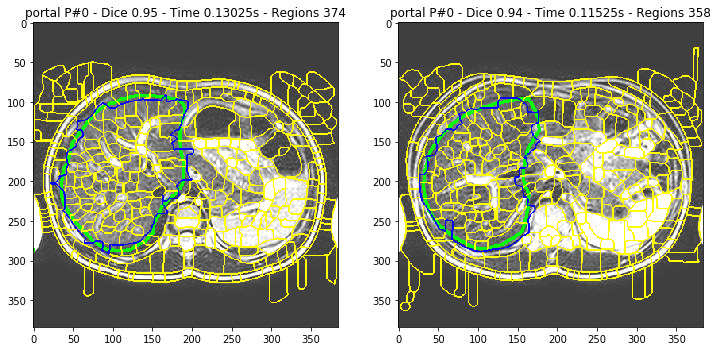

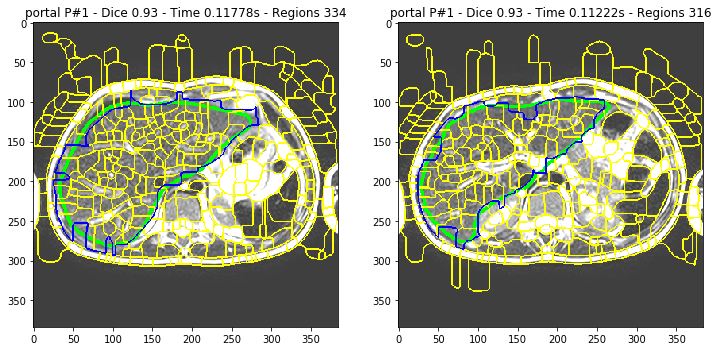

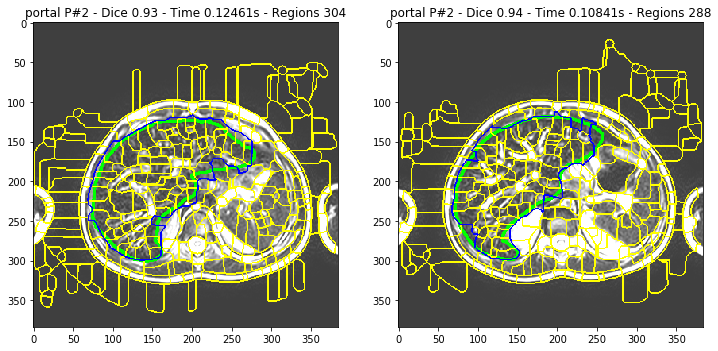

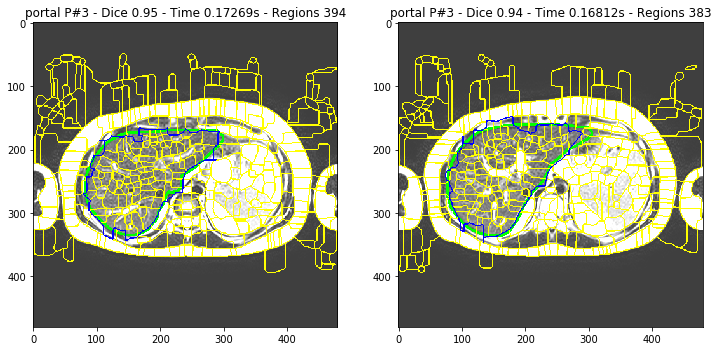

In [6]:
def watershed(image, sigma=5, r=5):
    """Compute a simple watershed on the Sobel of the image."""
    smoothed = skimage.filters.gaussian(image, sigma) # smooth with gaussian
    smoothed = smoothed/np.max(smoothed) # normalization to [0-1]
    magnitude = skimage.filters.sobel(smoothed) # Sobel for magnitude
    local_minima = skimage.morphology.local_minima(magnitude, selem=skimage.morphology.disk(r)) # get local minima
    markers = skimage.measure.label(local_minima) # label local minima
    return skimage.morphology.watershed(magnitude, markers)-1 # watershed; the -1 is for zeroing the background

for patient in range(4):
    # Computing labelmap for given method
    t0 = time()
    upper_labelmap = watershed(upper_slices[patient])
    t1 = time()
    optimal_labelmap = optimal_labeling(upper_labelmap, upper_truths[patient])
    optimal_dice = dice(optimal_labelmap, upper_truths[patient])
    # Plotting
    plt.figure(figsize=(12,12))
    plt.subplot(121)
    plt.imshow(skimage.segmentation.mark_boundaries(skimage.segmentation.mark_boundaries(skimage.segmentation.mark_boundaries(window_level(upper_slices[patient]), upper_truths[patient], mode="thick", color=(0,1,0), outline_color=(0,1,0)), upper_labelmap, color=(1,1,0),mode="thick"),optimal_labelmap,color=(0,0,1),mode="thick"), cmap="gray")
    plt.title("upper P#{} - Dice {:.2f} - Time {:.3f}s - Regions {}".format(patient, optimal_dice, t1-t0, len(np.unique(upper_labelmap))))
    
    t0 = time()
    portal_labelmap = watershed(portal_slices[patient])
    t1 = time()
    optimal_labelmap = optimal_labeling(portal_labelmap, portal_truths[patient])
    optimal_dice = dice(optimal_labelmap, portal_truths[patient])
    # Plotting
    plt.subplot(122)
    plt.imshow(skimage.segmentation.mark_boundaries(skimage.segmentation.mark_boundaries(skimage.segmentation.mark_boundaries(window_level(portal_slices[patient]), portal_truths[patient], mode="thick", color=(0,1,0), outline_color=(0,1,0)), portal_labelmap, color=(1,1,0),mode="thick"),optimal_labelmap,color=(0,0,1),mode="thick"), cmap="gray")
    plt.title("portal P#{} - Dice {:.2f} - Time {:.3f}s - Regions {}".format(patient, optimal_dice, t1-t0, len(np.unique(portal_labelmap))))
    plt.show()
    

### Region Merging

Let us utilize intensity-based region merging techniques to minimize the amount of regions on the super-segmentation map, while keeping the borders in which we are interested. We test several values of color merging thresholds and visualize the extremes of the thresholds.

Visualization is the same as above.

In [ ]:
def _weight_mean_color(graph, src, dst, n):
    """Callback to handle merging nodes by recomputing mean color.

    The method expects that the mean color of `dst` is already computed.

    Parameters
    ----------
    graph : RAG
        The graph under consideration.
    src, dst : int
        The vertices in `graph` to be merged.
    n : int
        A neighbor of `src` or `dst` or both.

    Returns
    -------
    data : dict
        A dictionary with the `"weight"` attribute set as the absolute
        difference of the mean color between node `dst` and `n`.
    """

    diff = graph.node[dst]['mean color'] - graph.node[n]['mean color']
    diff = np.linalg.norm(diff)
    return {'weight': diff}


def merge_mean_color(graph, src, dst):
    """Callback called before merging two nodes of a mean color distance graph.

    This method computes the mean color of `dst`.

    Parameters
    ----------
    graph : RAG
        The graph under consideration.
    src, dst : int
        The vertices in `graph` to be merged.
    """
    graph.node[dst]['total color'] += graph.node[src]['total color']
    graph.node[dst]['pixel count'] += graph.node[src]['pixel count']
    graph.node[dst]['mean color'] = (graph.node[dst]['total color'] /
                                     graph.node[dst]['pixel count'])



# Remaking the segmentation, then merging for each patient, with different thresholds
for thresh in [5, 10, 15, 20, 25, 30]:
    dices, times, regions = [],[],[]
    for patient in range(4):
        # Computing labelmap for given method
        upper_labelmap = watershed(upper_slices[patient])
        t0 = time()
        rag = skimage.future.graph.rag_mean_color(upper_slices[patient], upper_labelmap)
        upper_labelmap = skimage.future.graph.merge_hierarchical(upper_labelmap, rag, thresh=thresh, rag_copy=False,
                                       in_place_merge=True,
                                       merge_func=merge_mean_color,
                                       weight_func=_weight_mean_color)
        t1 = time()
        optimal_labelmap = optimal_labeling(upper_labelmap, upper_truths[patient])
        optimal_dice = dice(optimal_labelmap, upper_truths[patient])
        dices.append(optimal_dice)
        times.append(t1-t0)
        regions.append(len(np.unique(upper_labelmap)))
        
        portal_labelmap = watershed(portal_slices[patient])
        t0 = time()
        rag = skimage.future.graph.rag_mean_color(portal_slices[patient], portal_labelmap)
        portal_labelmap = skimage.future.graph.merge_hierarchical(portal_labelmap, rag, thresh=thresh, rag_copy=False,
                                       in_place_merge=True,
                                       merge_func=merge_mean_color,
                                       weight_func=_weight_mean_color)
        t1 = time()
        optimal_labelmap = optimal_labeling(portal_labelmap, portal_truths[patient])
        optimal_dice = dice(optimal_labelmap, portal_truths[patient])
        dices.append(optimal_dice)
        times.append(t1-t0)
        regions.append(len(np.unique(portal_labelmap)))
    
    print("Threshold {} Results: Dice {:.3f} -- Time {:.3f} -- Regions {}".format(thresh, np.mean(dices),np.mean(times),np.mean(regions)))

print("\n----------\n")
# Plotting threshs 5 and 30
for thresh in [5, 30]:
    for patient in range(4):
        # Computing labelmap for given method
        upper_labelmap = watershed(upper_slices[patient])
        t0 = time()
        rag = skimage.future.graph.rag_mean_color(upper_slices[patient], upper_labelmap)
        upper_labelmap = skimage.future.graph.merge_hierarchical(upper_labelmap, rag, thresh=thresh, rag_copy=False,
                                       in_place_merge=True,
                                       merge_func=merge_mean_color,
                                       weight_func=_weight_mean_color)
        t1 = time()
        optimal_labelmap = optimal_labeling(upper_labelmap, upper_truths[patient])
        optimal_dice = dice(optimal_labelmap, upper_truths[patient])
        #Plotting
        print("Threshold",thresh,":")
        plt.figure(figsize=(12,12))
        plt.subplot(121)
        plt.imshow(skimage.segmentation.mark_boundaries(skimage.segmentation.mark_boundaries(skimage.segmentation.mark_boundaries(window_level(upper_slices[patient]), upper_truths[patient], mode="thick", color=(0,1,0), outline_color=(0,1,0)), upper_labelmap, color=(1,1,0),mode="thick"),optimal_labelmap,color=(0,0,1),mode="thick"), cmap="gray")
        plt.title("upper P#{} - Dice {:.2f} - Time {:.3f}s - Regions {}".format(patient, optimal_dice, t1-t0, len(np.unique(upper_labelmap))))
    
        
        portal_labelmap = watershed(portal_slices[patient])
        t0 = time()
        rag = skimage.future.graph.rag_mean_color(portal_slices[patient], portal_labelmap)
        portal_labelmap = skimage.future.graph.merge_hierarchical(portal_labelmap, rag, thresh=thresh, rag_copy=False,
                                       in_place_merge=True,
                                       merge_func=merge_mean_color,
                                       weight_func=_weight_mean_color)
        t1 = time()
        optimal_labelmap = optimal_labeling(portal_labelmap, portal_truths[patient])
        optimal_dice = dice(optimal_labelmap, portal_truths[patient])
        #Plotting
        plt.subplot(122)
        plt.imshow(skimage.segmentation.mark_boundaries(skimage.segmentation.mark_boundaries(skimage.segmentation.mark_boundaries(window_level(portal_slices[patient]), portal_truths[patient], mode="thick", color=(0,1,0), outline_color=(0,1,0)), portal_labelmap, color=(1,1,0),mode="thick"),optimal_labelmap,color=(0,0,1),mode="thick"), cmap="gray")
        plt.title("portal P#{} - Dice {:.2f} - Time {:.3f}s - Regions {}".format(patient, optimal_dice, t1-t0, len(np.unique(portal_labelmap))))
        plt.show()